# About

Python code that cleans, processes, and plots data from Portuguese naval logbooks. Main objective is to gather climactic, geographic, and chronological information. Part of the "Historical Records" project led by Dr. Caroline Ummenhofer.

* **Author**: Livia Stein Freitas - 2024 WHOI Summer Student Fellow
* **Project Investigator**: Dr. Caroline Ummenhofer - Woods Hole Oceanographic Institution
* **Collaborators**: Tessa Giacoppo and Theo Carr
* **Historian**: Dr. Timothy Walker - University of Massachusetts Dartmouth
* **Home Institution**: Woods Hole Oceanographic Institution (WHOI) - Physical Oceanography Department
* **Technical aspects**:
    - *Language*: Python.
    - *Main libraries*: Pandas, Matplotlib, Cartopy, and Numpy.
    - *Testing framework*: unittest.
    - *Data naming convention*: 'Portuguese_Naval_Log_Entries_{MonthDay}_{Year}.csv'. Example: 'Portuguese_Naval_Log_Entries_June20_24.csv'
* **Start Date**: May 2024

More information about the project on: https://ummenhofer.whoi.edu/historical-records/

# Set-up: imports

## Package imports

In [1]:
# Imported from DataDistributions_May13 on Jun 6, 2024 by Livia

import numpy as np  # for large, multidimensional arrays
import pandas as pd  # for data analysis and manipulation
import xarray as xr  # for labelled multi-dimensional arrays
import matplotlib.pyplot as plt  # for creating data visualizations
import matplotlib.ticker as ticker  # for data points and labels on the graphs
import datetime, os  # for representing date and time / for using operating system functionalities
import cartopy.crs as ccrs  # for processing geospatial data (coordinate reference systems in particular)
import cartopy.feature as cfeature  # for drawing and filtering data
import seaborn as sns  # for high-level data visualization
from collections import Counter  # for counting unique types
import math  # for math :)
import re  # for regular expressions
import unittest  # for testing procedures

pd.options.display.max_columns = 50

print("Last updated on {}".format(datetime.datetime.now().ctime()))

Last updated on Thu Jun 27 17:51:34 2024


## Data imports

In [2]:
# Labels that correspond to missing data
na_values = ("n/a", "N/A", "000 00 00Z", "00 00 00Z", " ", "NaN", "nan")

# Read CSV dataframe
# df = pd.read_csv('Portuguese_Naval_Log_Entries_May28_24.csv', na_values=na_values)
df = pd.read_csv("Portuguese_Naval_Log_Entries_June20_24.csv", na_values=na_values)

### Remove test entries

In [15]:
df = df.drop(df.loc[df["Researcher"] == "Webapp Support"].index, axis=0)

# Data Processing

## Potential steps for handling the data
1. Handling missing values
2. Removing repeat data
3. Standardizing the format (spelling or otherwise)
4. Checking that numerical values are within possible range

## Creating general processing procedures and the df_u dataframe

In [40]:
# Create dataframe for processed data
df_u = pd.DataFrame()
new_series = pd.Series([])

def get_usable_series(old_series, new_series):
    """Return a new dataframe series with only non-n/a values."""
    for index, value in old_series.items():
        if pd.notna(old_series[index]):
            new_series[index] = value
    return new_series


def remove_unusual_chars(unusual_char, entry):
    """Takes in a regex pattern of unusual characters. Returns a string without unusual characters."""
    modified_entry = entry
    if re.search(unusual_char, modified_entry):
        modified_entry = re.sub(unusual_char, "", modified_entry)
    return modified_entry

<bound method Series.items of 0             NaN
1       38 41 44N
2       37 27 00N
3       36 30 00N
4       35 42 00N
          ...    
2236          NaN
2237          NaN
2238          NaN
2239          NaN
2240          NaN
Name: Lat Start, Length: 2240, dtype: object>

### Getting information about the data

In [5]:
# find out what types are included in the latitude data

types_list = []
lat_start = df["Lat Start"]
for value in lat_start:
    value_type = type(value)
    types_list.append(value_type)
types = Counter(types_list).keys()

# find out how many entries are floats/strings


def is_str(value):
    return isinstance(value, str)


str_list = list(filter(is_str, lat_start))
length = 0
for s in str_list:
    length += 1
print("number of string entries: " + str(length))


def is_float(value):
    return isinstance(value, float)


float_list = list(filter(is_float, lat_start))
length_f = 0
for f in float_list:
    length_f += 1
print("number of float entries: " + str(length_f))

number of string entries: 1015
number of float entries: 1225


### Tests

## Researcher

In [7]:
#df_u["Researcher"] = get_usable_series(df["Researcher"], new_series)
#df_u.index[df_u['Researcher']=="Timothy Walker"].tolist()

## Latitude and Longitude Values

### Process for getting valid numerical entries
1. Remove n/a values (floats): use get_usable_series()
2. Standardize remaining values: use standardize_latitude() and standardize_longitude()
3. Check whether values are within the range of possibility: use is_lat_possible() and is_long_possible()
4. Make values numerical: use make_ll_numerical()

## Procedures

In [8]:
# Checking procedures


def is_lat_standard(entry):
    """Checks that the entry has the format XX XX XXY, where the Xs are integers and Y is 'N' or 'S' (North or South). Returns a boolean."""
    lat_pattern = r"\d{2}\s\d{2}\s\d{2}[NS]$"
    matches = re.match(lat_pattern, entry)
    return matches is not None


def is_long_standard(entry):
    """Checks that the entry has the format XXX XX XXY, where the Xs are integers and Y is 'W' or 'E' (West or East). Returns a boolean."""
    long_pattern = r"\d{2,3}\s\d{2}\s\d{2}[WE]$"
    matches = re.match(long_pattern, entry)
    return matches is not None


def is_lat_possible(entry):
    """Checks that the value of a latitude string is between -90 and 90. Return a boolean."""
    entry = standardize_latitude(entry)
    if is_lat_standard(entry):
        entry = entry[0:-1].replace(
            " ", ""
        )  # removes whitespace and the directional letter
        entry = int(entry)
        return entry >= -900000 and entry <= 900000


def is_long_possible(entry):
    """Checks that a longitude string is between -180 and 180. Returns a boolean."""
    entry = standardize_longitude(entry)
    if is_long_standard(entry):
        entry = entry[0:-1].replace(
            " ", ""
        )  # removes whitespace and the directional letter
        entry = int(entry)
        return entry >= -1800000 and entry <= 1800000


# Standardizing procedures


def standardize_latitude(entry):
    """Checks what kind of common quirk a latitude string has and corrects it. Returns a string."""

    if is_lat_standard(entry):
        return entry

    else:
        modified_entry = entry  # create a new variable for modification

        # if it has an unusual character, like '*', remove it
        unusual_pattern = r"[^\d\sNS]"
        modified_entry = remove_unusual_chars(unusual_pattern, modified_entry)

        # if missing direction, assign 'N' as the default direction
        if not re.search(r"[NS]", modified_entry):
            modified_entry += "N"

        # if there is a space between the digits and the direction, remove it
        extra_space_pattern = r".*\s+[NS]"
        if re.match(extra_space_pattern, modified_entry):
            modified_entry = modified_entry[:-2] + modified_entry[-1:]

        # if missing seconds, add 00 to entry[-3]
        digits = re.sub(r"[^\d]", "", modified_entry)
        if len(digits) == 4:
            modified_entry = modified_entry[0:5] + " 00" + modified_entry[-1]

        return modified_entry


def standardize_longitude(entry):
    """Checks what kind of common quirk a longitude string has and corrects it. Returns a string."""

    if is_long_standard(entry):
        return entry

    else:
        modified_entry = entry  # Create a new variable for modification

        # if entry contains an unusual character, i.e.: '&', remove it
        unusual_pattern = r"[^\d\sEW]"
        modified_entry = remove_unusual_chars(unusual_pattern, modified_entry)

        # if missing direction, assign 'W' as the default direction
        if not re.search(r"[EW]", modified_entry):
            modified_entry += "W"

        # if there is a space between the digits and the direction, remove it
        extra_space_pattern = r".*\s+[EW]"
        if re.match(extra_space_pattern, modified_entry):
            modified_entry = modified_entry[:-2] + modified_entry[-1:]

        # if entry is missing seconds, add 00 to entry[-3]
        digits = re.sub(r"[^\d]", "", modified_entry)
        if len(digits) == 4:
            modified_entry = modified_entry[0:5] + " 00" + modified_entry[-1]
        elif len(digits) == 5:
            modified_entry = modified_entry[0:6] + " 00" + modified_entry[-1]

        return modified_entry


def make_ll_numerical(entry):
    """Transforms entry from a string with format XX XX XXY into an XX.XXXX float. Returns a float."""
    if (is_lat_standard(entry)) | (is_long_standard(entry)):
        modified_entry = entry

        # Remove whitespace
        modified_entry = modified_entry.replace(" ", "")

        # Remove direction
        direction_values = r"[NSWE]"
        direction = re.search(direction_values, entry)
        modified_entry = re.sub(
            direction_values, "", modified_entry
        )  # Use modified_entry here

        # Make value into an integer
        modified_entry = int(modified_entry)

        # Make value positive or negative depending on the direction
        direction_match = re.search(direction_values, entry)
        if direction_match and direction_match.group() in ("S", "W"):
            modified_entry = modified_entry * (-1)

        modified_entry = modified_entry / 10000
        return float(modified_entry)
    else:
        print("Entry " + entry + " is not standard. Can't make it numerical.")

## Tests

In [9]:
class TestLatitudeLongitudeMethods(unittest.TestCase):

    def test_standardize_latitude(self):
        self.assertEqual(
            standardize_latitude("12 34 56'N"), "12 34 56N"
        )  # unusual character
        self.assertEqual(
            standardize_latitude("12 34 56 N"), "12 34 56N"
        )  # space between digits and direction
        self.assertEqual(
            standardize_latitude("12 34 56 E"), "12 34 56N"
        )  # nonstandard direction
        self.assertEqual(
            standardize_latitude("12 34 56"), "12 34 56N"
        )  # missing direction
        self.assertEqual(
            standardize_latitude("12 34 N"), "12 34 00N"
        )  # missing seconds
        self.assertEqual(
            standardize_latitude("12 34 56' W"), "12 34 56N"
        )  # unusual character, spacing, and direction

    def test_standardize_longitude(self):
        self.assertEqual(
            standardize_longitude("12 34 56'W"), "12 34 56W"
        )  # unusual character
        self.assertEqual(
            standardize_longitude("12 34 56 W"), "12 34 56W"
        )  # space between digits and direction
        self.assertEqual(
            standardize_longitude("12 34 56 E"), "12 34 56E"
        )  # nonstandard direction
        self.assertEqual(
            standardize_longitude("12 34 56"), "12 34 56W"
        )  # missing direction
        self.assertEqual(
            standardize_longitude("12 34 W"), "12 34 00W"
        )  # missing seconds
        self.assertEqual(
            standardize_longitude("12 34 56' N"), "12 34 56W"
        )  # unusual character, spacing, and direction


res = unittest.main(argv=[""], verbosity=3, exit=False)

test_standardize_latitude (__main__.TestLatitudeLongitudeMethods.test_standardize_latitude) ... ok
test_standardize_longitude (__main__.TestLatitudeLongitudeMethods.test_standardize_longitude) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


## Applying procedures

In [25]:
# Latitude and Longitude values

# NOTE: atm this doesn't account for entries with valid latitude but not longitude and vice versa.
# this could cause a length/index mismatch issue

new_series = pd.Series([])

# Get non-n/a values
df_u["Lat_Start"] = get_usable_series(df["Lat Start"], new_series)
df_u["Lat_End"] = get_usable_series(df["Lat End"], new_series)
df_u["Long_Start"] = get_usable_series(df["Long Start"], new_series)
df_u["Long_End"] = get_usable_series(df["Long End"], new_series)

# Standardize values

df_u["Lat_Start"] = df_u["Lat_Start"].apply(standardize_latitude)
df_u["Long_Start"] = df_u["Long_Start"].apply(standardize_longitude)
df_u["Lat_End"] = df_u["Lat_End"].apply(standardize_latitude)
df_u["Long_End"] = df_u["Long_End"].apply(standardize_longitude)

# Make values numerical

df_u["Lat_Start"] = df_u["Lat_Start"].apply(make_ll_numerical)
df_u["Long_Start"] = df_u["Long_Start"].apply(make_ll_numerical)
df_u["Lat_End"] = df_u["Lat_End"].apply(make_ll_numerical)
df_u["Long_End"] = df_u["Long_End"].apply(make_ll_numerical)

1014

## Log Entry Date and Year

### Creating Procedures

In [11]:
# Split the date string to get the year value.
""" entry_years = []
for date in log_entry_dates:
    entry_years.append(date[0:4]) """


def is_date_standard(entry):
    """Checks if date has the format XXXX-XX-XX, where X is a digit between 0 and 9."""
    date_pattern = r"\d{4}-\d{2}-\d{2}$"
    matches = re.match(date_pattern, entry)
    return matches is not None


def standardize_date(entry):
    """Ensures date entry has the format XXXX-XX-XX, where X is a digit between 0 and 9."""
    pass


def get_year(entry):
    """Gets year from a date entry with the format XXXX-XX-XX."""
    if is_date_standard(entry):
        modified_entry = entry[0:4]
        modified_entry = float(modified_entry)
        return modified_entry

    else:
        print("Entry " + entry + " does not have format XXXX-XX-XX. Cannot get year.")

### Processing data

In [17]:
df_u["Date"] = get_usable_series(df["Log Entry Date"], new_series)
df_u["Year"] = df_u["Date"].apply(get_year)

# Find typos

# Drop typos
df_u = df_u.drop(df_u.index[df_u['Year']==1943], axis=0)
df_u.index[df_u['Year']==1978].tolist()

1014

## Logbook Record Number

## Landmarks

# Figures

## Geographic Distribution of Entries, Color-coded by Year (Lat/Long Start)

Total number of plotted values: 1014


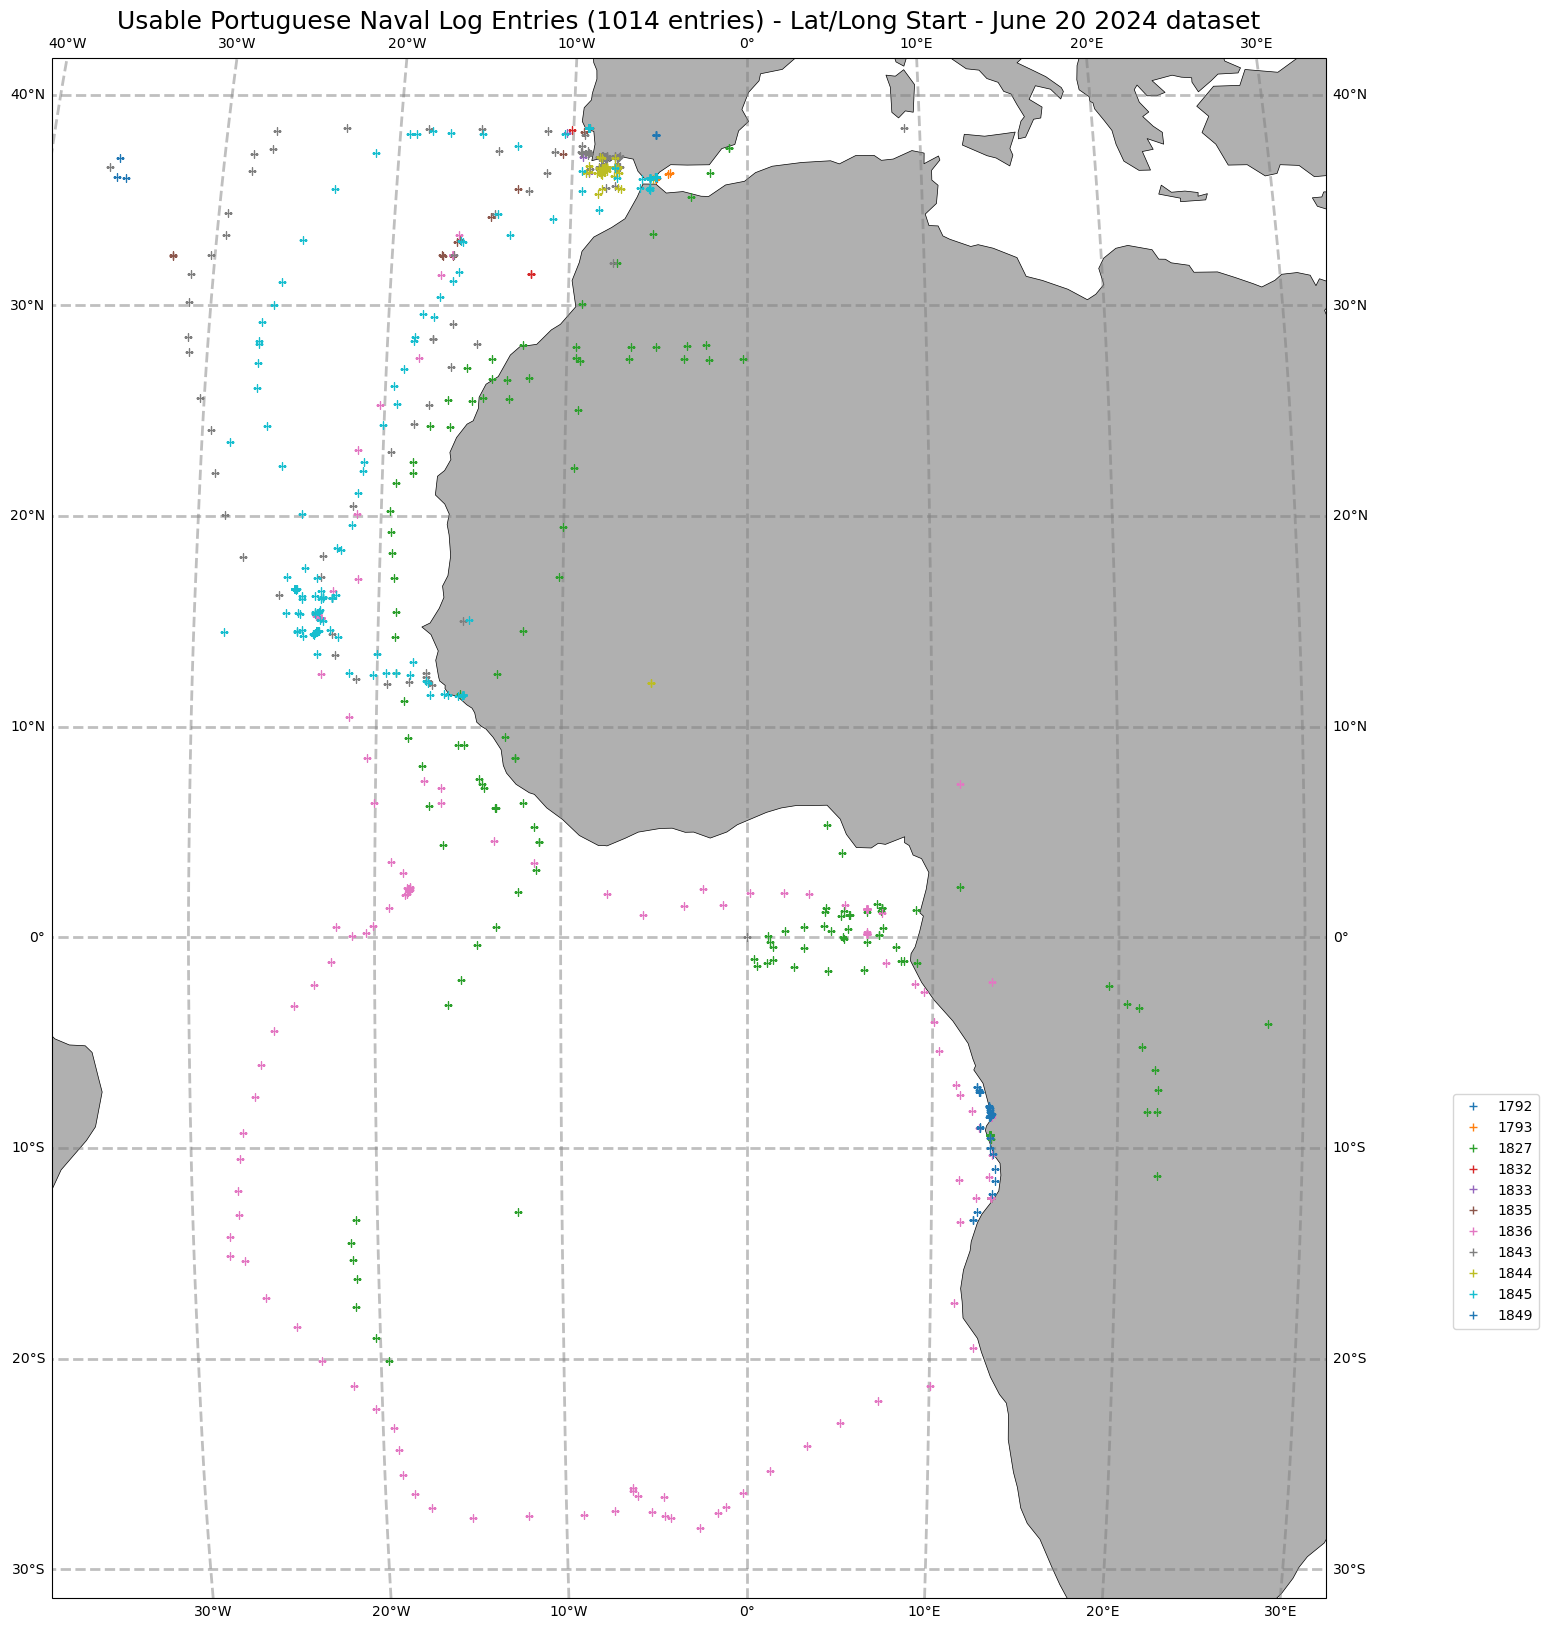

In [22]:
# Using Lat Start and Long Start

fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={"projection": ccrs.Robinson()})
# _ = ax.set_global()
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor="#b0b0b0")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=2,
    color="gray",
    alpha=0.5,
    linestyle="--",
)

# Initialize counter for the number of plotted values
num_plotted_values = 0

for yr in sorted(df_u["Year"].unique()):
    work = df_u[df_u["Year"] == yr]
    _ = ax.plot(
        work.Long_Start,
        work.Lat_Start,
        "+",
        transform=ccrs.PlateCarree(),
        label="{:.0f}".format(yr),
    )
    num_plotted_values += len(work)

_ = ax.legend(loc=(1.1, 0.175))


# Change for each tier
plt.title(
    "Usable Portuguese Naval Log Entries (" + str(num_plotted_values) + " entries) - Lat/Long Start - June 20 2024 dataset",
    fontsize=18,
)
# fig.savefig(os.path.join(Data, 'Tier1_NA_Unique Years_May13_24.png'),dpi=300,bbox_inches='tight')

# Print the total number of plotted values
print("Total number of plotted values:", num_plotted_values)

## Geographic Distribution of Entries, Color-coded by Year (Lat/Long End)

Total number of plotted values: 1014


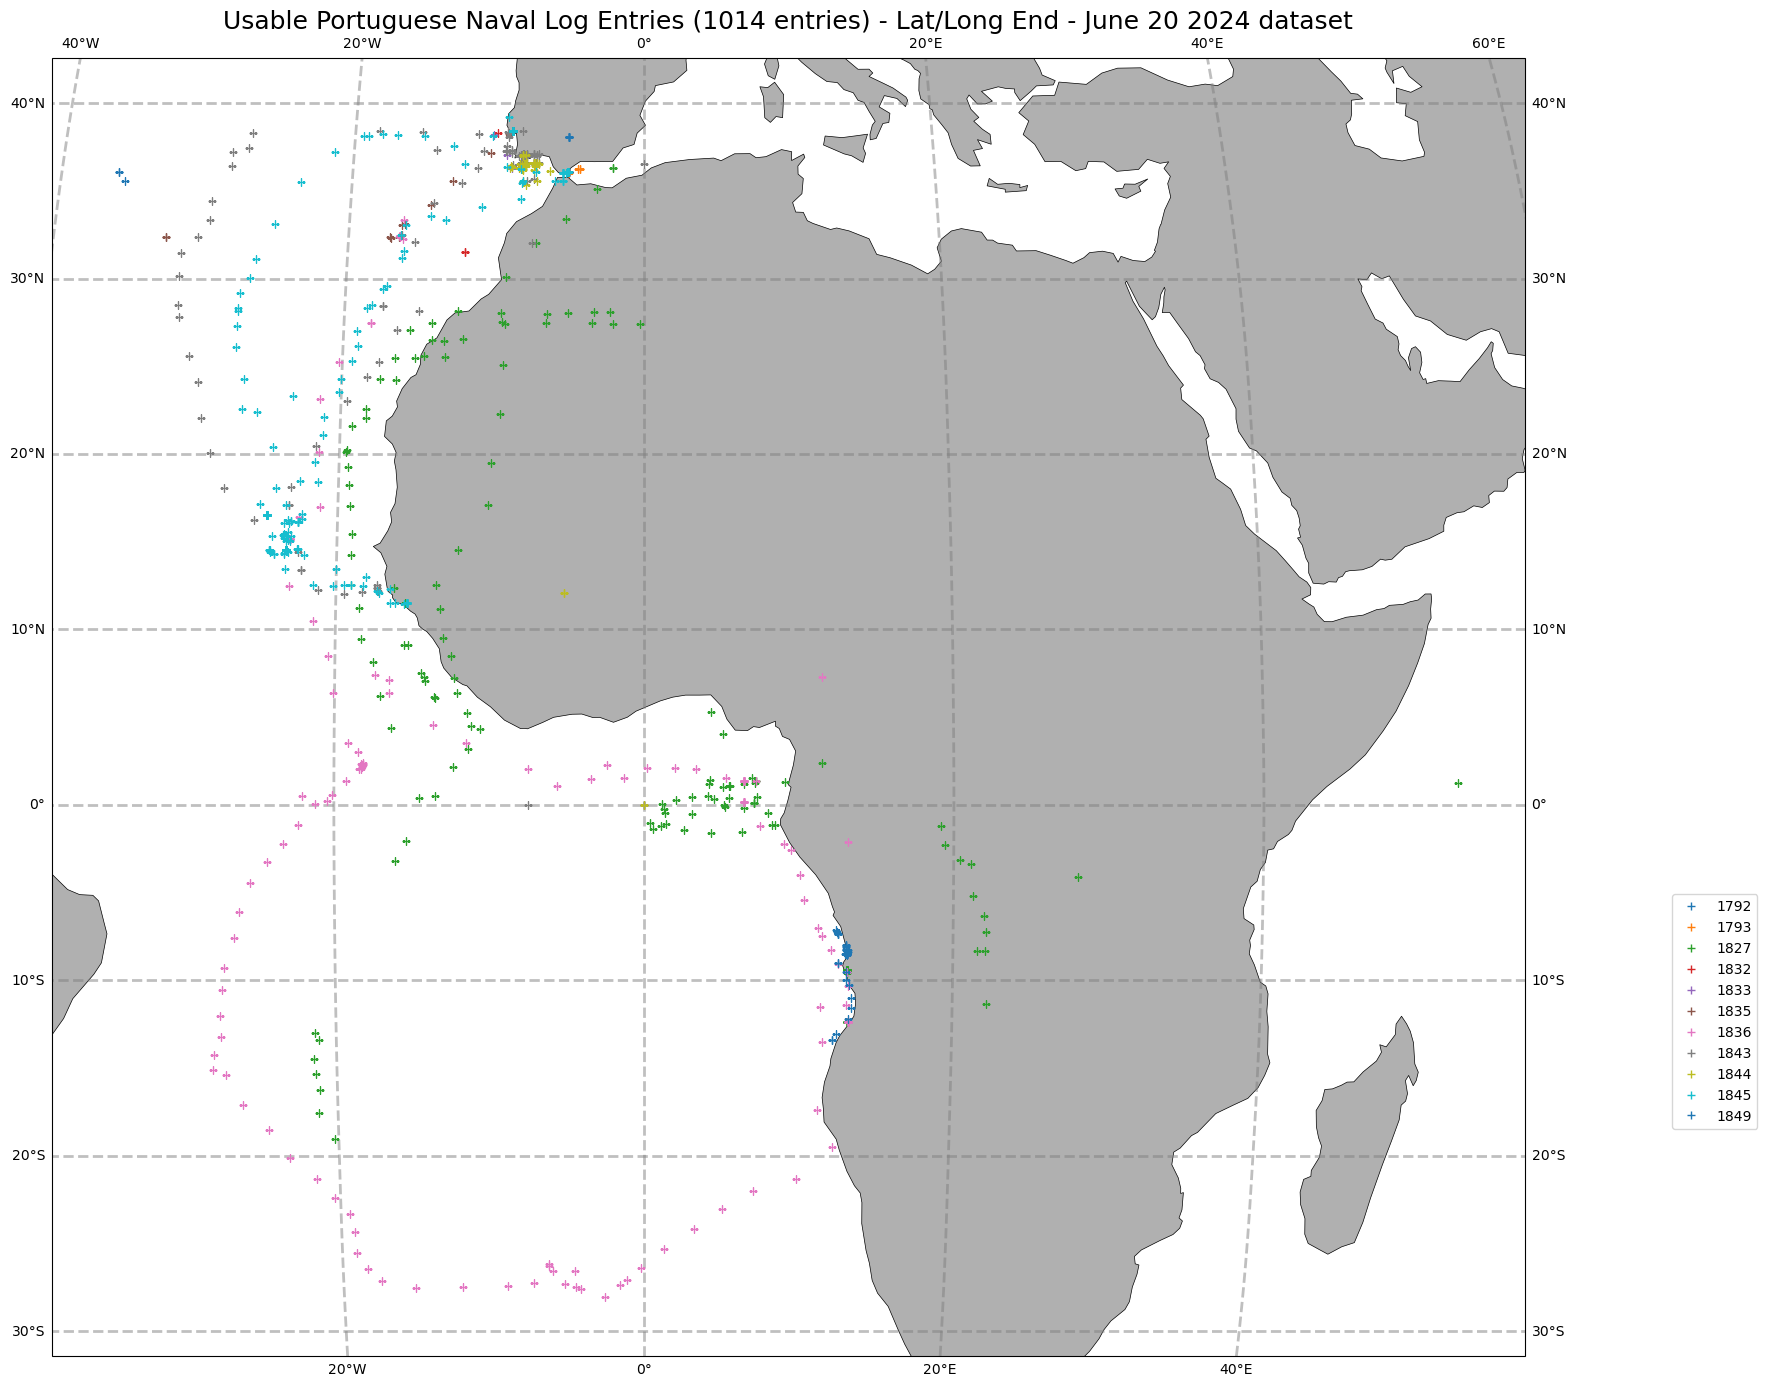

In [21]:
# Using Lat End and Long End

fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={"projection": ccrs.Robinson()})
# _ = ax.set_global()
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor="#b0b0b0")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=2,
    color="gray",
    alpha=0.5,
    linestyle="--",
)

# Initialize counter for the number of plotted values
num_plotted_values = 0

for yr in sorted(df_u["Year"].unique()):
    work = df_u[df_u["Year"] == yr]
    _ = ax.plot(
        work.Long_End,
        work.Lat_End,
        "+",
        transform=ccrs.PlateCarree(),
        label="{:.0f}".format(yr),
    )
    num_plotted_values += len(work)

_ = ax.legend(loc=(1.1, 0.175))


# Change for each tier
plt.title(
    "Usable Portuguese Naval Log Entries (" + str(num_plotted_values) + " entries) - Lat/Long End - June 20 2024 dataset",
    fontsize=18,
)
# fig.savefig(os.path.join(Data, 'Tier1_NA_Unique Years_May13_24.png'),dpi=300,bbox_inches='tight')

# Print the total number of plotted values
print("Total number of plotted values:", num_plotted_values)

## Entries per Year

In [ ]:
# Generate a list of years from 1792 to 1913
all_years = np.arange(1790, 1850)

# Plot the count of entries per year
f, ax = plt.subplots(figsize=(12, 14))
sns.countplot(y=df_u["Year"], order=all_years, ax=ax)
ax.grid(alpha=0.2)

# Set y-tick labels to display only every 10 years
# ax.set_yticks(10)
# ax.set_yticklabels(all_years[::10])
tick_spacing = 10
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# Change for each tier
plt.title("Number of Entries per Year - June 20 2024 dataset", fontsize=18)
# plt.savefig(os.path.join(Data, 'Number_of_Entries_per_Year_May28_24.png'), dpi=300, bbox_inches='tight')

### References Used

1. Base code for "Geographic Distribution of Entries, Color-coded by Year", "Entries by Year" supplied by Tessa Giacoppo. 
2. https://docs.python.org/3/library/	re.html#search-vs-match 
3. How To Remove Spaces from a String In Python | DigitalOcean 
4. Difference between 'and' and '&' in Python - GeeksforGeeks 
5. Drop rows from the dataframe based on certain condition applied on a column - GeeksforGeeks
6. Pi.ai for debugging is_lat_possible, matching the end of a regular expression to the character Z (is_ll_na), and dropping rows that return False for is_ll_na.
7. Theo Carr and Richard Bley helped me debug regular expressions errors I encountered.
8. Difference between map, applymap and apply methods in Pandas - GeeksforGeeks
9. https://stackoverflow.com/questions/24878174/how-to-count-digits-letters-spaces-for-a-string-in-python 
